In [2]:
#Save the data 
!wget https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/RSV/geography_types/Nation/geographies/England/metrics/RSV_healthcare_admissionRateByWeek

--2024-10-25 10:05:55--  https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/RSV/geography_types/Nation/geographies/England/metrics/RSV_healthcare_admissionRateByWeek
Resolving api.ukhsa-dashboard.data.gov.uk (api.ukhsa-dashboard.data.gov.uk)... 108.138.217.88, 108.138.217.92, 108.138.217.42, ...
Connecting to api.ukhsa-dashboard.data.gov.uk (api.ukhsa-dashboard.data.gov.uk)|108.138.217.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2120 (2.1K) [application/json]
Saving to: ‘RSV_healthcare_admissionRateByWeek.1’

RSV_healthcare_admi 100%[===================>]   2.07K  --.-KB/s    in 0s      

2024-10-25 10:05:55 (640 MB/s) - ‘RSV_healthcare_admissionRateByWeek.1’ saved [2120/2120]



In [3]:
!cat RSV_healthcare_admissionRateByWeek

{"count":2167,"next":"https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/RSV/geography_types/Nation/geographies/England/metrics/RSV_healthcare_admissionRateByWeek?page=2","previous":null,"results":[{"theme":"infectious_disease","sub_theme":"respiratory","topic":"RSV","geography_type":"Nation","geography":"England","geography_code":"E92000001","metric":"RSV_healthcare_admissionRateByWeek","metric_group":"healthcare","stratum":"default","sex":"all","age":"45-54","year":2020,"month":9,"epiweek":40,"date":"2020-09-28","metric_value":0.0,"in_reporting_delay_period":false},{"theme":"infectious_disease","sub_theme":"respiratory","topic":"RSV","geography_type":"Nation","geography":"England","geography_code":"E92000001","metric":"RSV_healthcare_admissionRateByWeek","metric_group":"healthcare","stratum":"default","sex":"all","age":"05-14","year":2020,"month":9,"epiweek":40,"date":"2020-09-28","metric_value":0.0,"in_reporting_delay_period":false},{"the

In [4]:
import requests 
requests.get("https://api.ukhsa-dashboard.data.gov.uk/themes"
             "/infectious_disease/sub_themes/respiratory/topics"
             "/RSV/geography_types/Nation/geographies/England"
             "/metrics/RSV_healthcare_admissionRateByWeek",
             params={'year':2020, 'page_size':3, 'page':2}).json()

{'count': 130,
 'next': 'https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/RSV/geography_types/Nation/geographies/England/metrics/RSV_healthcare_admissionRateByWeek?page=3&page_size=3&year=2020',
 'previous': 'https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/RSV/geography_types/Nation/geographies/England/metrics/RSV_healthcare_admissionRateByWeek?page_size=3&year=2020',
 'results': [{'theme': 'infectious_disease',
   'sub_theme': 'respiratory',
   'topic': 'RSV',
   'geography_type': 'Nation',
   'geography': 'England',
   'geography_code': 'E92000001',
   'metric': 'RSV_healthcare_admissionRateByWeek',
   'metric_group': 'healthcare',
   'stratum': 'default',
   'sex': 'all',
   'age': '55-64',
   'year': 2020,
   'month': 9,
   'epiweek': 40,
   'date': '2020-09-28',
   'metric_value': 0.0,
   'in_reporting_delay_period': False},
  {'theme': 'infectious_disease',
   'sub_theme': 'respiratory'

In [6]:
import requests 
import time 

class APIwrapper:
    # class variables shared among all instances
    _access_point="https://api.ukhsa-dashboard.data.gov.uk"
    _last_access=0.0 # time of last api access
    
    def __init__(self, theme, sub_theme, topic, geography_type, geography, metric):
        """ Init the APIwrapper object, constructing the endpoint from the structure
        parameters """
        # build the path with all the required structure parameters
        url_path=(f"/themes/{theme}/sub_themes/{sub_theme}/topics/{topic}/geography_types/" +
                  f"{geography_type}/geographies/{geography}/metrics/{metric}")
        # our starting API endpoint
        self._start_url=APIwrapper._access_point+url_path
        self._filters=None
        self._page_size=-1
        # will contain the number of items
        self.count=None

    def get_page(self, filters={}, page_size=5):
        """ Access the API and download the next page of data. Sets the count
        attribute to the total number of items available for this query. Changing
        filters or page_size will cause get_page to restart from page 1. Rate
        limited to three request per second. The page_size parameter sets the number
        of data points in one response page (maximum 365); use the default value 
        for debugging your structure and filters, increase when you start looping 
        over all pages. """
        # Check page size is within range
        if page_size>130:
            raise ValueError("Max supported page size is 365")
        # restart from first page if page or filters have changed
        if filters!=self._filters or page_size!=self._page_size:
            self._filters=filters
            self._page_size=page_size
            self._next_url=self._start_url
        # signal the end of data condition
        if self._next_url==None: 
            return [] # we already fetched the last page
        # simple rate limiting to avoid bans
        curr_time=time.time() # Unix time: number of seconds since the Epoch
        deltat=curr_time-APIwrapper._last_access
        if deltat<0.33: # max 3 requests/second
            time.sleep(0.33-deltat)
        APIwrapper._last_access=curr_time
        # build parameter dictionary by removing all the None
        # values from filters and adding page_size
        parameters={x: y for x, y in filters.items() if y!=None}
        parameters['page_size']=page_size
        # the page parameter is already included in _next_url.
        # This is the API access. Response is a dictionary with various keys.
        # the .json() method decodes the response into Python object (dictionaries,
        # lists; 'null' values are translated as None).
        response = requests.get(self._next_url, params=parameters).json()
        # update url so we'll fetch the next page
        self._next_url=response['next']
        self.count=response['count']
        # data are in the nested 'results' list
        return response['results'] 

In [7]:
structure={"theme": "infectious_disease", 
           "sub_theme": "respiratory",
           "topic": "RSV",
           "geography_type": "Nation", 
           "geography": "England"}

In [8]:
structure["metric"]="RSV_healthcare_admissionRateByWeek" 

In [9]:
# ** unpacks the structure dictionary over the __init__ arguments
api=APIwrapper(**structure)
data=api.get_page() # default size is 5
print(api.count)
print(data)

2167
[{'theme': 'infectious_disease', 'sub_theme': 'respiratory', 'topic': 'RSV', 'geography_type': 'Nation', 'geography': 'England', 'geography_code': 'E92000001', 'metric': 'RSV_healthcare_admissionRateByWeek', 'metric_group': 'healthcare', 'stratum': 'default', 'sex': 'all', 'age': '45-54', 'year': 2020, 'month': 9, 'epiweek': 40, 'date': '2020-09-28', 'metric_value': 0.0, 'in_reporting_delay_period': False}, {'theme': 'infectious_disease', 'sub_theme': 'respiratory', 'topic': 'RSV', 'geography_type': 'Nation', 'geography': 'England', 'geography_code': 'E92000001', 'metric': 'RSV_healthcare_admissionRateByWeek', 'metric_group': 'healthcare', 'stratum': 'default', 'sex': 'all', 'age': '05-14', 'year': 2020, 'month': 9, 'epiweek': 40, 'date': '2020-09-28', 'metric_value': 0.0, 'in_reporting_delay_period': False}, {'theme': 'infectious_disease', 'sub_theme': 'respiratory', 'topic': 'RSV', 'geography_type': 'Nation', 'geography': 'England', 'geography_code': 'E92000001', 'metric': 'RSV_

In [10]:
# Let's filter for the year 2020.
# None values will be ignored by the APIwrapper

filters={"stratum" : None, # Smallest subgroup a metric can be broken down into e.g. ethnicity, testing pillar
         "age": None, # Smallest subgroup a metric can be broken down into e.g. 15_44 for the age group of 15-44 years
         "sex": None, #  Patient gender e.g. 'm' for Male, 'f' for Female or 'all' for all genders
         "year": 2020, #  Epi year of the metrics value (important for annual metrics) e.g. 2020
         "month": None, # Epi month of the metric value (important for monthly metrics) e.g. 12
         "epiweek" :None, # Epi week of the metric value (important for weekly metrics) e.g. 30
         "date" : None, # The date which this metric value was recorded in the format YYYY-MM-DD e.g. 2020-07-20
         "in_reporting_delay_period": None # Boolean indicating whether the data point is considered to be subject to retrospective updates
        }

In [11]:
data_2020=api.get_page(filters, page_size=3)
print(api.count)
print(data_2020)

130
[{'theme': 'infectious_disease', 'sub_theme': 'respiratory', 'topic': 'RSV', 'geography_type': 'Nation', 'geography': 'England', 'geography_code': 'E92000001', 'metric': 'RSV_healthcare_admissionRateByWeek', 'metric_group': 'healthcare', 'stratum': 'default', 'sex': 'all', 'age': 'all', 'year': 2020, 'month': 9, 'epiweek': 40, 'date': '2020-09-28', 'metric_value': 0.0, 'in_reporting_delay_period': False}, {'theme': 'infectious_disease', 'sub_theme': 'respiratory', 'topic': 'RSV', 'geography_type': 'Nation', 'geography': 'England', 'geography_code': 'E92000001', 'metric': 'RSV_healthcare_admissionRateByWeek', 'metric_group': 'healthcare', 'stratum': 'default', 'sex': 'all', 'age': '65-74', 'year': 2020, 'month': 9, 'epiweek': 40, 'date': '2020-09-28', 'metric_value': 0.0, 'in_reporting_delay_period': False}, {'theme': 'infectious_disease', 'sub_theme': 'respiratory', 'topic': 'RSV', 'geography_type': 'Nation', 'geography': 'England', 'geography_code': 'E92000001', 'metric': 'RSV_hea

In [12]:
# The original structure, just in case you edited it:
structure={"theme": "infectious_disease", 
           "sub_theme": "respiratory",
           "topic": "RSV",
           "geography_type": "Nation", 
           "geography": "England"}

In [13]:
structure["metric"]="RSV_healthcare_admissionRateByWeek"
api=APIwrapper(**structure)
admissions=[]
page=1
while True:
    data=api.get_page(page_size=130)
    print(f"Pages retrieved: {page}")
    if data==[]:
        break
    admissions.extend(data)
    page+=1
print(f"Data points expected: {api.count}")
print(f"Data points retrieved: {len(admissions)}")


Pages retrieved: 1
Pages retrieved: 2
Pages retrieved: 3
Pages retrieved: 4
Pages retrieved: 5
Pages retrieved: 6
Pages retrieved: 7
Pages retrieved: 8
Pages retrieved: 9
Pages retrieved: 10
Pages retrieved: 11
Pages retrieved: 12
Pages retrieved: 13
Pages retrieved: 14
Pages retrieved: 15
Pages retrieved: 16
Pages retrieved: 17
Pages retrieved: 18
Data points expected: 2167
Data points retrieved: 2167


In [14]:
structure["metric"]="RSV_testing_positivityByWeek"
# the structure has changed, so we need to create a new object
api=APIwrapper(**structure)
tests=[]
while True:
    data=api.get_page(page_size=130)
    if data==[]:
        break
    tests.extend(data)

In [15]:
import json 

In [16]:
with open("admissions.json", "wt") as OUTF:
    json.dump(admissions, OUTF)

In [17]:
with open("tests.json", "wt") as OUTF:
    json.dump(tests, OUTF)

## Visualising the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json

In [2]:
# an iPython  "magic" that enables the embedding of matplotlib output
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

In [3]:
with open("admissions.json", "rt") as INFILE:
    admissions=json.load(INFILE)
with open("tests.json", "rt") as INFILE:
    tests=json.load(INFILE)

In [5]:
admissions[:5]

[{'theme': 'infectious_disease',
  'sub_theme': 'respiratory',
  'topic': 'RSV',
  'geography_type': 'Nation',
  'geography': 'England',
  'geography_code': 'E92000001',
  'metric': 'RSV_healthcare_admissionRateByWeek',
  'metric_group': 'healthcare',
  'stratum': 'default',
  'sex': 'all',
  'age': '45-54',
  'year': 2020,
  'month': 9,
  'epiweek': 40,
  'date': '2020-09-28',
  'metric_value': 0.0,
  'in_reporting_delay_period': False},
 {'theme': 'infectious_disease',
  'sub_theme': 'respiratory',
  'topic': 'RSV',
  'geography_type': 'Nation',
  'geography': 'England',
  'geography_code': 'E92000001',
  'metric': 'RSV_healthcare_admissionRateByWeek',
  'metric_group': 'healthcare',
  'stratum': 'default',
  'sex': 'all',
  'age': '05-14',
  'year': 2020,
  'month': 9,
  'epiweek': 40,
  'date': '2020-09-28',
  'metric_value': 0.0,
  'in_reporting_delay_period': False},
 {'theme': 'infectious_disease',
  'sub_theme': 'respiratory',
  'topic': 'RSV',
  'geography_type': 'Nation',
  '

In [6]:
data={}
for dataset in [admissions, tests]:
    for entry in dataset:
        date=entry['date']
        metric=entry['metric']
        value=entry['metric_value']
        if date not in data:
            data[date]={}
        data[date][metric]=value

In [7]:
data

{'2020-09-28': {'RSV_healthcare_admissionRateByWeek': 0.0,
  'RSV_testing_positivityByWeek': 0.38},
 '2020-10-05': {'RSV_healthcare_admissionRateByWeek': 0.0,
  'RSV_testing_positivityByWeek': 0.32},
 '2020-10-12': {'RSV_healthcare_admissionRateByWeek': 0.0,
  'RSV_testing_positivityByWeek': 0.0},
 '2020-10-19': {'RSV_healthcare_admissionRateByWeek': 0.0,
  'RSV_testing_positivityByWeek': 0.0},
 '2020-10-26': {'RSV_healthcare_admissionRateByWeek': 0.03,
  'RSV_testing_positivityByWeek': 0.0},
 '2020-11-02': {'RSV_healthcare_admissionRateByWeek': 0.0,
  'RSV_testing_positivityByWeek': 0.0},
 '2020-11-09': {'RSV_healthcare_admissionRateByWeek': 0.0,
  'RSV_testing_positivityByWeek': 0.0},
 '2020-11-16': {'RSV_healthcare_admissionRateByWeek': 0.0,
  'RSV_testing_positivityByWeek': 0.26},
 '2020-11-23': {'RSV_healthcare_admissionRateByWeek': 0.0,
  'RSV_testing_positivityByWeek': 0.0},
 '2020-11-30': {'RSV_healthcare_admissionRateByWeek': 0.0,
  'RSV_testing_positivityByWeek': 0.0},
 '2020

In [8]:
data['2020-09-28']

{'RSV_healthcare_admissionRateByWeek': 0.0,
 'RSV_testing_positivityByWeek': 0.38}

In [9]:
dates=list(data.keys())
dates.sort()
dates

['2017-07-03',
 '2017-07-10',
 '2017-07-17',
 '2017-07-24',
 '2017-07-31',
 '2017-08-07',
 '2017-08-14',
 '2017-08-21',
 '2017-08-28',
 '2017-09-04',
 '2017-09-11',
 '2017-09-18',
 '2017-09-25',
 '2017-10-02',
 '2017-10-09',
 '2017-10-16',
 '2017-10-23',
 '2017-10-30',
 '2017-11-06',
 '2017-11-13',
 '2017-11-20',
 '2017-11-27',
 '2017-12-04',
 '2017-12-11',
 '2017-12-18',
 '2017-12-25',
 '2018-01-01',
 '2018-01-08',
 '2018-01-15',
 '2018-01-22',
 '2018-01-29',
 '2018-02-05',
 '2018-02-12',
 '2018-02-19',
 '2018-02-26',
 '2018-03-05',
 '2018-03-12',
 '2018-03-19',
 '2018-03-26',
 '2018-04-02',
 '2018-04-09',
 '2018-04-16',
 '2018-04-23',
 '2018-04-30',
 '2018-05-07',
 '2018-05-14',
 '2018-05-21',
 '2018-05-28',
 '2018-06-04',
 '2018-06-11',
 '2018-06-18',
 '2018-06-25',
 '2018-07-02',
 '2018-07-09',
 '2018-07-16',
 '2018-07-23',
 '2018-07-30',
 '2018-08-06',
 '2018-08-13',
 '2018-08-20',
 '2018-08-27',
 '2018-09-03',
 '2018-09-10',
 '2018-09-17',
 '2018-09-24',
 '2018-10-01',
 '2018-10-

In [10]:
def parse_date(datestring):
    """ Convert a date string into a pandas datetime object """
    return pd.to_datetime(datestring, format="%Y-%m-%d")

In [11]:
startdate=parse_date(dates[0])
enddate=parse_date(dates[-1])
print (startdate, ' to ', enddate)

2017-07-03 00:00:00  to  2024-10-14 00:00:00


In [12]:
index=pd.date_range(startdate, enddate, freq='W-MON')
timeseriesdf=pd.DataFrame(index=index, columns=['admissions', 'tests'])
timeseriesdf

,admissions,tests
2017-07-03,NaN,NaN
2017-07-10,NaN,NaN
2017-07-17,NaN,NaN
2017-07-24,NaN,NaN
2017-07-31,NaN,NaN
...,...,...
2024-09-16,NaN,NaN
2024-09-23,NaN,NaN
2024-09-30,NaN,NaN
2024-10-07,NaN,NaN


In [13]:
# translate the columns to our metrics
metrics ={'admissions': 'RSV_healthcare_admissionRateByWeek',
          'tests': 'RSV_testing_positivityByWeek'}

for date, entry in data.items(): # each entry is a dictionary with cases, admissions and deaths
    pd_date=parse_date(date) # convert to Pandas format
    for column in ['admissions', 'tests']: 
        metric_name=metrics[column]
        # do not assume all values are there for every date - if a value is not available, insert a 0.0
        value= entry.get(metric_name, 0.0)
        # this is the way you access a specific location in the dataframe - use .loc
        # and put index,column in a single set of [ ]
        timeseriesdf.loc[date, column]=value
            
# fill in any remaining "holes" due to missing dates
timeseriesdf.fillna(0.0, inplace=True)
            
timeseriesdf
# # Translate the columns to our metrics
# metrics = {
#     'admissions': 'RSV_healthcare_admissionRateByWeek',
#     'tests': 'RSV_testing_positivityByWeek'
# }

# for date, entry in data.items():  # Each entry is a dictionary
#     pd_date = parse_date(date)  # Convert to Pandas format
#     # Convert to monthly period
#     monthly_period = pd_date.to_period('M').to_timestamp()

#     if monthly_period in timeseriesdf.index:  # Check if the monthly period is in the index
#         for column in ['admissions', 'tests']: 
#             metric_name = metrics[column]
#             # Insert 0.0 if the value is not available
#             value = entry.get(metric_name, 0.0)
#             timeseriesdf.loc[monthly_period, column] = value

# # Fill in any remaining "holes" due to missing months
# timeseriesdf.fillna(0.0, inplace=True)
# timeseriesdf = timeseriesdf.resample('M').sum()

,admissions,tests
2017-07-03,0.0,0.69
2017-07-10,0.0,0.0
2017-07-17,0.0,0.75
2017-07-24,0.0,1.91
2017-07-31,0.0,0.0
...,...,...
2024-09-16,0.0,0.13
2024-09-23,0.0,0.18
2024-09-30,0.0,0.23
2024-10-07,0.51,1.97


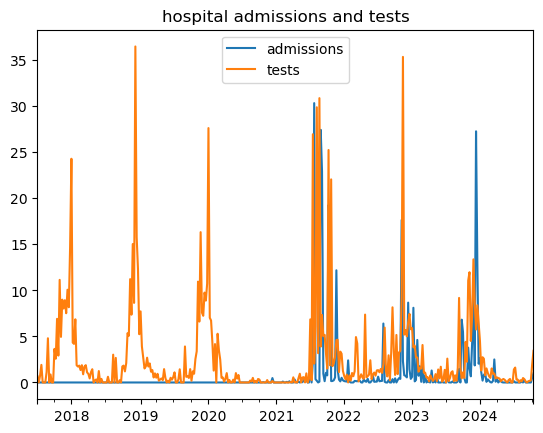

In [14]:
ax=timeseriesdf.plot() # easy peasy...
ax.set_title('hospital admissions and tests');
# ax = timeseriesdf.plot(title='Monthly Hospital Admissions and Tests')
# ax.set_xlabel('Date')
# ax.set_ylabel('Counts')
# ax.legend(title='Metrics')
# Print the DataFrame to debug
# print(timeseriesdf)

# # Plot the DataFrame
# ax = timeseriesdf.plot(title='Monthly Hospital Admissions and Tests')
# ax.set_xlabel('Date')
# ax.set_ylabel('Counts')
# ax.legend(title='Metrics')

# # Optional: Set y-limits for better visibility
# # ax.set_ylim(0, timeseriesdf.max().max() * 1.1)  # Adjust as needed

# # Show the plot
# import matplotlib.pyplot as plt
# plt.show()


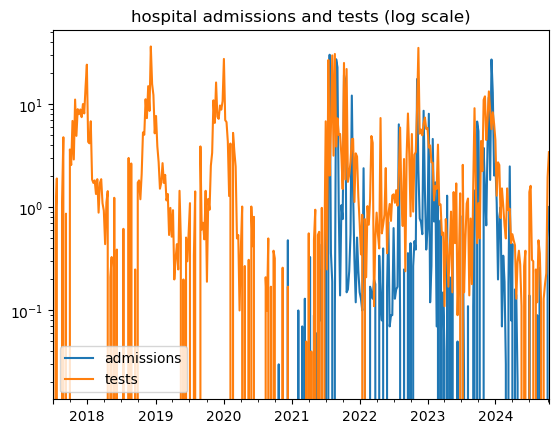

In [15]:
ax=timeseriesdf.plot(logy=True) # ...lemon squeezy
ax.set_title('hospital admissions and tests (log scale)');

NameError: name 'quarterly' is not defined

## Disease dashboard

In [16]:
from IPython.display import clear_output
import ipywidgets as wdg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import time
import json

In [17]:
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

In [18]:
# Load JSON files and store the raw data in some variable. Edit as appropriate
jsondata={}

In [19]:

def wrangle_data(rawdata):
    """ Parameters: rawdata - data from json file or API call. Returns a dataframe.
    Edit to include the code that wrangles the data, creates the dataframe and fills it in. """
    df=pd.DataFrame(index=range(0,100), columns=['One', 'Two'])
    # we have no real data to wrangle, so we just generate two random walks.
    one=two=0.0
    for i in range(0,100):
        df.loc[i,'One']=one
        df.loc[i,'Two']=two
        one+=np.random.randn()
        two+=2*np.random.randn()
    return df

# putting the wrangling code into a function allows you to call it again after refreshing the data through 
# the API. You should call the function directly on the JSON data when the dashboard starts, by including 
# the call in this cell as below:
df=wrangle_data(jsondata) # df is the dataframe for plotting

In [22]:
# Place your API access code in this function. Do not call this function directly; it will be called by 
# the button callback. 
def access_api():
    url = "https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/RSV/geography_types/Nation/geographies/England/metrics/RSV_healthcare_admissionRateByWeek"
    """ Accesses the UKHSA API. Return data as a like-for-like replacement for the "canned" data loaded from the JSON file. """
    return {} # return data read from the API

In [23]:
# Printout from this function will be lost in Voila unless captured in an
# output widget - therefore, we give feedback to the user by changing the 
# appearance of the button
def api_button_callback(button):
    """ Button callback - it must take the button as its parameter (unused in this case).
    Accesses API, wrangles data, updates global variable df used for plotting. """
    # Get fresh data from the API. If you have time, include some error handling
    # around this call.
    apidata=access_api()
    # wrangle the data and overwrite the dataframe for plotting
    global df
    df=wrangle_data(apidata)
    # the graph won't refresh until the user interacts with the widget.
    # this function simulates the interaction, see Graph and Analysis below.
    # The function needs to be adapted to your graph; you can omit this call
    # in the first instance
    refresh_graph()
    # after all is done, you can switch the icon on the button to a "check" sign
    # and optionally disable the button - it won't be needed again. If you are 
    # implementing error handling, you can use icons "unlink" or "times" and 
    # change the button text to "Unavailable" when the api call fails.
    apibutton.icon="check"
    # apibutton.disabled=True

    
apibutton=wdg.Button(
    description='PANIC', # you may want to change this...
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Keep calm and carry on",
    # FontAwesome names without the `fa-` prefix - try "download"
    icon='exclamation-triangle'
)

# remember to register your button callback function with the button
apibutton.on_click(api_button_callback) # the name of your function inside these brackets

display(apibutton)

# run all cells before clicking on this button

Button(button_style='danger', description='PANIC', icon='exclamation-triangle', style=ButtonStyle(), tooltip='…

In [24]:
def plot_random_walk(walk):
    """ Our sample graph plotting function """
    df[walk].plot()
    plt.show() # important! update won't work properly without this

# a sample widget
whichwalk=wdg.Dropdown(
    options=['One', 'Two'],
    value='One',
    description='Walk no: ',
    disabled=False,
)

def refresh_graph():
    """ We change the value of the widget in order to force a redraw of the graph;
    this is useful when the data have been updated. This is a bit of a gimmick; it
    needs to be customised for one of your widgets. """
    current=whichwalk.value
    if current==whichwalk.options[0]:
        other=whichwalk.options[1]
    else:
        other=whichwalk.options[0]
    whichwalk.value=other # forces the redraw
    whichwalk.value=current # now we can change it back
    
# connect the plotting function and the widget    
graph=wdg.interactive_output(plot_random_walk, {'walk': whichwalk})

# actually displays the graph
display(whichwalk, graph)

Dropdown(description='Walk no: ', options=('One', 'Two'), value='One')

Output()